<h2> Problem Statement</h2>
<hr />
<p> 
<b>Description :</b> The Conversation AI team, a research initiative founded by Jigsaw and Google (both part of Alphabet), builds technology to protect voices in conversation. Challenge here is to build machine learning models that detect toxicity and reduce unwanted bias. For example, if a certain minority name is frequently associated with toxic comments, some models might associate the presence of the minority name in a message that is not toxic and wrongly classify the comment as toxic.
<br/>
<br/>
<b>Toxicity</b> is defined as anything <b>rude, disrespectful or otherwise likely to make someone leave a discussion</b>.
<br/>
<br/>
<b> Inshort, we need to Detect toxicity in the comments along with minimizing unintended bias.</b>
</p>
<br />

<h2>Business Constraints & Understanding as a machine learning problem</h2>
<hr />
>>  Latency requirement is not mentioned. so we consider evaluation time to be a few seconds.
<br />
>>  Some form of interpretibility of the results
<br />
>>  Model Evaluation metric - overall AUC + generalized mean of bias AUC's.
<br />
<br />

In [0]:
# @title import
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import datetime
import os
import pandas as pd
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 500)
pd.options.display.max_rows
pd.set_option('display.max_colwidth', 500)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
import numpy as np
import pkg_resources
import seaborn as sns
import time
import scipy.stats as stats

import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from tqdm import tqdm
from bs4 import BeautifulSoup
import string
import re

import matplotlib.pyplot as plt
%matplotlib inline

import pickle

from sklearn import metrics
from sklearn import model_selection
from gensim.models import KeyedVectors

import keras
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical, plot_model
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, concatenate
from keras.layers import Input
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.layers import Flatten, add
from keras.layers import Dropout, BatchNormalization
from keras.layers import Dense
from keras.layers import CuDNNLSTM,CuDNNGRU, BatchNormalization, SpatialDropout1D, Bidirectional
from keras.optimizers import RMSprop
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
from keras import regularizers

import tensorflow as tf

import warnings
warnings.filterwarnings("ignore")

# uncomment these lines for the first time.

# Download and unzip files used in this colab
!curl -O -J -L https://storage.googleapis.com/civil_comments/fat_star_tutorial/fat-star.zip
!unzip -o fat-star.zip
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -o glove.6B.zip
!curl -O -J -L https://dl.fbaipublicfiles.com/fasttext/vectors-english/crawl-300d-2M.vec.zip
!unzip -o crawl-300d-2M.vec.zip
# Seed for Pandas sampling, to get consistent sampling results
RANDOM_STATE = 123456789

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Using TensorFlow backend.


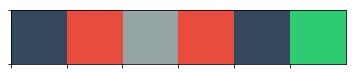

In [0]:
# @title Utility
import gc
def garbageCollection():
  collected = gc.collect()
  print("Garbage collector: collected","%d objects." % collected)
  
flatui = ["#34495e","#e74c3c", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.palplot(sns.color_palette(flatui))

In [0]:
# @title Load Data

# Read the initial train, test, and validate data into Pandas dataframes.
train_df_float = pd.read_csv('public_train.csv')
test_df_float = pd.read_csv('public_test.csv')
validate_df_float = pd.read_csv('public_validate.csv')

print('training data has %d rows' % len(train_df_float))
print('validation data has %d rows' % len(validate_df_float))
print('test data has %d rows' % len(test_df_float))
print('training data columns are: %s' % train_df_float.columns)

training data has 1289508 rows
validation data has 161193 rows
test data has 161233 rows
training data columns are: Index(['id', 'comment_text', 'data_set', 'created_date', 'publication_id', 'parent_id', 'article_id', 'rating', 'funny', 'wow', 'sad', 'likes', 'disagree', 'toxicity', 'severe_toxicity', 'obscene', 'sexual_explicit', 'identity_attack', 'insult', 'threat', 'male', 'female', 'transgender', 'other_gender', 'heterosexual', 'homosexual_gay_or_lesbian', 'bisexual', 'other_sexual_orientation', 'christian', 'jewish', 'muslim', 'hindu', 'buddhist', 'atheist', 'other_religion', 'black', 'white', 'asian', 'latino', 'other_race_or_ethnicity', 'physical_disability', 'intellectual_or_learning_disability', 'psychiatric_or_mental_illness', 'other_disability', 'identity_annotator_count', 'toxicity_annotator_count'], dtype='object')


In [0]:
# @title View Sample Data
pd.concat([
    # Select 3 rows where 100% of raters said it applied to the male identity.
    train_df_float[['toxicity', 'male', 'comment_text']].query('male == 1').head(3),
    # Select 3 rows where 50% of raters said it applied to the male identity.
    train_df_float[['toxicity', 'male', 'comment_text']].query('male == 0.5').head(3),
    # Select 3 rows where 0% of raters said it applied to the male identity.
    train_df_float[['toxicity', 'male', 'comment_text']].query('male == 0.0').head(3),
    # Select 3 rows that were not labeled for the male identity (have NaN values).
    # See https://stackoverflow.com/questions/26535563 if you would like to
    # understand this Pandas behavior.
    train_df_float[['toxicity', 'male', 'comment_text']].query('male != male').head(3)])

,toxicity,male,comment_text
4988,0.545455,1.0,Blame men. There's always an excuse to blame men for the failures of women.
4994,0.800000,1.0,"Are you a Pilgrim?\nWhy arn't you growing your own veggies? \nAnd do you haul them in a covered wagon?\n\nThankfully it isn't up to ""white man"" to determine what is traditional for the First Peoples of Alaska.\nBut they try to all the time and it looks pathetic."
4999,0.363636,1.0,"No, he was accused of being a racist white man."
5426,0.646154,0.5,"You come from the 'veins of polygamy'.... is Zuma your father?? Polygamy is wholly primitive, debasing women! \nOK, not certain about paternity, but I am certain that Mbabula is a crass racist e=who has enriched himself while, so far, making an idiot of himself as a Minister in his 'father's' Government. \nIt's very clear whe know where you stand Mbabula, and Law and Order doesn't come into it!"
5644,0.737500,0.5,53% of white women voted for the guy who advises to grab 'em by the p*ssy. So much for the sisterhood.
5854,0.657143,0.5,"""remarkable woman""??? Are you nuts? What am I saying, of course you're nuts. She was a flawed woman who would tell two lies to two different people to get a vote. She flip flopped like a fish on the dock. She cheated and lied her way through 3 decades of public service like we have never seen before. Had she been a man she would have been cast aside a long time ago.\nShe is despicable, not remarkable."
4986,0.757143,0.0,Why is this black racist crap still on the G&M website?\n\nI stopped talking to black people long ago because I was afraid for my life!!!!!\nSince 80%-90% of all crime is by black people it kinda makes sense doesn't it.\nOh wait thats profiling or is it driving while black? \nI don't know you LEFTIST MARXISTS and BLM nutjobs change the names so fast no one can keep up.\nSo what do we do when the facts speak like this?\nWash it all away by letting identity Marxists spew their racist hatred o...
4987,0.688525,0.0,even up here.......BLACKS!
4989,0.728571,0.0,And the woman exposing herself saying grab this pussy is an offer I take? She definitely is the sane and high class American that you gloat about trying to represent
0,0.373134,NaN,He got his money... now he lies in wait till after the election in 2 yrs.... dirty politicians need to be afraid of Tar and feathers again... but they aren't and so the people get screwed.


In [0]:
train_df_float.head(2)

,id,comment_text,data_set,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,toxicity,severe_toxicity,obscene,sexual_explicit,identity_attack,insult,threat,male,female,transgender,other_gender,heterosexual,homosexual_gay_or_lesbian,bisexual,other_sexual_orientation,christian,jewish,muslim,hindu,buddhist,atheist,other_religion,black,white,asian,latino,other_race_or_ethnicity,physical_disability,intellectual_or_learning_disability,psychiatric_or_mental_illness,other_disability,identity_annotator_count,toxicity_annotator_count
0,1083994,He got his money... now he lies in wait till after the election in 2 yrs.... dirty politicians need to be afraid of Tar and feathers again... but they aren't and so the people get screwed.,bucket4,2017-03-06 15:21:53.675241+00,21,NaN,317120,approved,0,0,0,2,0,0.373134,0.044776,0.089552,0.014925,0.000000,0.343284,0.014925,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,67
1,650904,Mad dog will surely put the liberals in mental hospitals. Boorah,bucket3,2016-12-02 16:44:21.329535+00,21,NaN,154086,approved,0,0,1,2,0,0.605263,0.013158,0.065789,0.013158,0.092105,0.565789,0.065789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,76


In [0]:
# @title Constants
MAX_PAD_SEQ_LEN = 220
TOXICITY_COLUMN = 'toxicity'

TEXT_COLUMN = 'comment_text'

IDENTITY_COLUMNS = ['male', 'female', 'homosexual_gay_or_lesbian','christian',
                    'jewish', 'muslim', 'black', 'white', 'asian']

AUXILARY_COLUMNS = ['severe_toxicity', 'obscene','identity_attack', 
                    'insult', 'threat']

GLOVE_EMBEDDINGS_PATH = 'glove.6B.300d.txt'
GLOVE_EMBEDDINGS_DIMENSION = 300

CRAWL_EMBEDDINGS_PATH = 'crawl-300d-2M.vec'
CRAWL_EMBEDDINGS_DIMENSION = 300


In [0]:
garbageCollection()

Garbage collector: collected 1578 objects.


In [0]:
# @title Basic Data Preprocessing
# Convert taget and identity columns to booleans
def convert_to_bool(df, col_name):
  if col_name in df.columns:
    df[col_name] = np.where(df[col_name] >= 0.5, True, False)

    
def convert_dataframe_to_bool(df):
  # List all identities
  identity_columns = [
          'male', 'female', 'transgender', 'other_gender', 'heterosexual',
          'homosexual_gay_or_lesbian', 'bisexual', 'other_sexual_orientation', 
          'christian', 'jewish', 'muslim', 'hindu', 'buddhist', 'atheist', 
          'other_religion', 'black', 'white', 'asian', 'latino', 
          'other_race_or_ethnicity', 'physical_disability', 
          'intellectual_or_learning_disability',
          'psychiatric_or_mental_illness', 'other_disability']
  bool_df = df.copy()
  for col in [TOXICITY_COLUMN] + identity_columns:
    convert_to_bool(bool_df, col)
  return bool_df

train_df_float = convert_dataframe_to_bool(train_df_float)
validate_df_float = convert_dataframe_to_bool(validate_df_float)

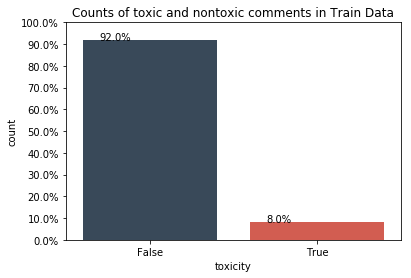

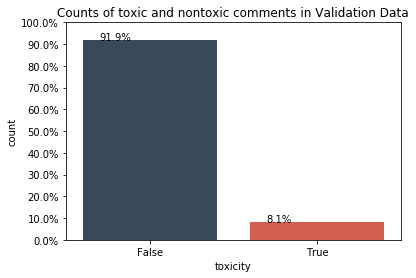

Distributions of features on Train Data 



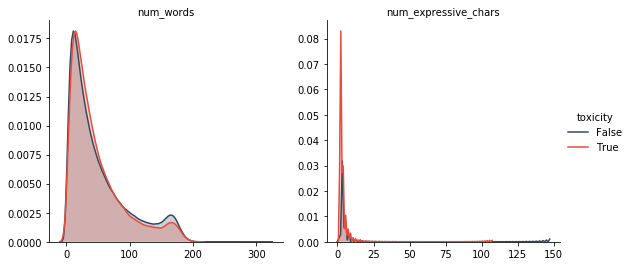

Distributions of features on Validate Data 



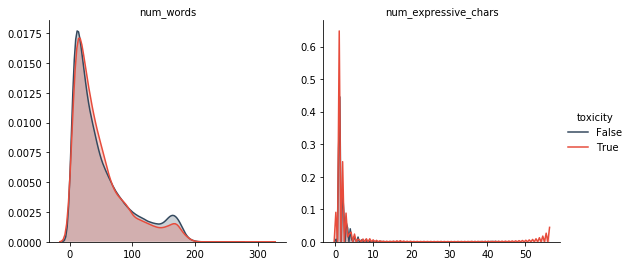

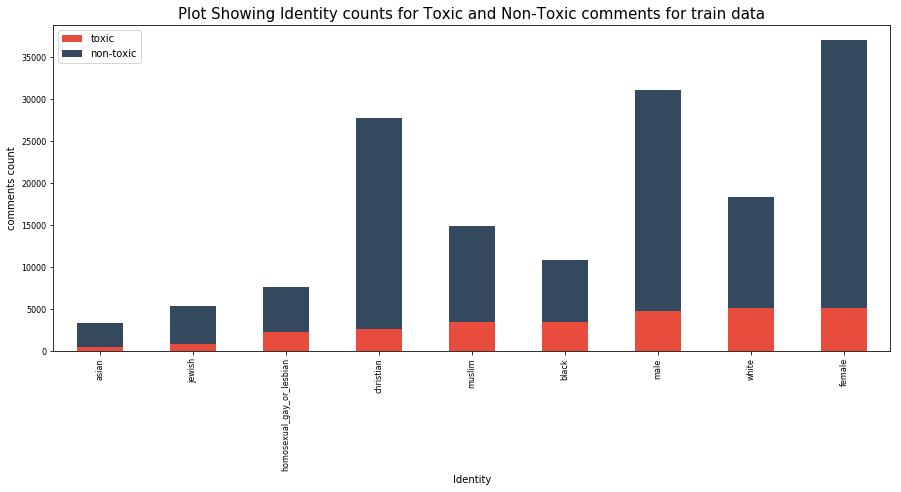

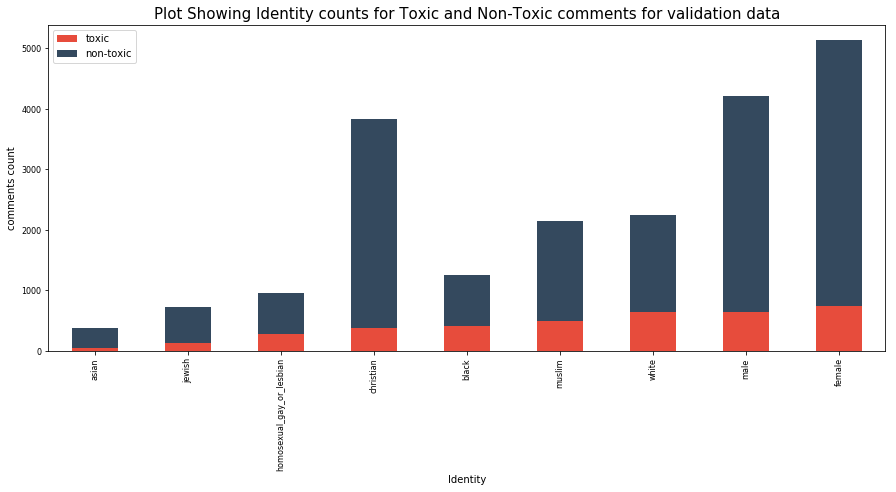

In [0]:
# @title Data Analysis (Before Preprocessing)
# toxic and non toxic counts

def toxic_nontoxic_count(df, title):
  total = df.shape[0]*1
  ax=sns.countplot(x=TOXICITY_COLUMN, data=df, palette=sns.color_palette(flatui))
  for p in ax.patches:
    ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))
  #put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
  ax.yaxis.set_ticks(np.linspace(0, total, 11))
  #adjust the ticklabel to the desired format, without changing the position of the ticks.
  ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
  plt.title(title)
  plt.show()

toxic_nontoxic_count(train_df_float, "Counts of toxic and nontoxic comments in Train Data")
toxic_nontoxic_count(validate_df_float, "Counts of toxic and nontoxic comments in Validation Data")

# extract number of words and number of expressive chars for a comment
def extract_features(df):
  df['num_words'] = df['comment_text'].apply(lambda comment: len(comment.split()))
  # Count number of question marks.
  no_of_que= df['comment_text'].apply(lambda comment: comment.count('?'))
  no_of_excl = df['comment_text'].apply(lambda comment: comment.count('!'))
  df['num_expressive_chars'] = no_of_que+no_of_excl

extract_features(train_df_float)
extract_features(validate_df_float)

# plot the distributions on columns of dataframe 
# with toxicity column as a separator
def show_dist(df, title):
  df = pd.melt(df, id_vars=TOXICITY_COLUMN, 
              var_name='features', value_name = 'value')
  fg = sns.FacetGrid(df, palette = sns.color_palette(flatui), col='features', hue=TOXICITY_COLUMN, 
                        sharex=False, sharey=False, size=4)
  fg.map(sns.kdeplot, 'value', shade=True, label='Data')\
          .add_legend()\
          .set_titles("{col_name}")\
          .set_axis_labels('')
 
  plt.show()

  plt.clf()
  plt.close('all')
  del df
# train features 
print( "Distributions of features on Train Data \n")
show_dist(train_df_float[[TOXICITY_COLUMN, 
                               'num_words',
                               'num_expressive_chars']],
         "Distributions of features on Train Data")
# validate features
print( "Distributions of features on Validate Data \n")
show_dist(validate_df_float[[TOXICITY_COLUMN, 
                               'num_words',
                               'num_expressive_chars']],
         "Distributions of features on Validate Data")


# plot the identities count in toxic and non-toxic comments
def identity_counts(df, feature_columns, title):
  # A stacked graph on toxic and non-toxic count for each feature.
  toxic = df[df[TOXICITY_COLUMN] >= .5][feature_columns]
  non_toxic = df[df[TOXICITY_COLUMN] < .5][feature_columns]
  toxic_count = toxic.where(toxic == 0, other = 1).sum()
  non_toxic_count = non_toxic.where(non_toxic == 0, other = 1).sum()
  toxic_vs_non_toxic = pd.concat([ toxic_count,non_toxic_count], axis=1).rename(index=str, columns={ 1: "non-toxic", 0: "toxic",})
  toxic_vs_non_toxic.sort_values(by='toxic').plot(kind='bar', colors=[flatui[1], flatui[0]], stacked=True, figsize=(15,6), fontsize=8).legend(prop={'size': 10})
  plt.title(title, fontsize=15)
  plt.xlabel("Identity")
  plt.ylabel("comments count")
  plt.show()
  plt.close()

# train 
identity_counts(train_df_float, IDENTITY_COLUMNS, 
                "Plot Showing Identity counts for Toxic and Non-Toxic comments for train data")
identity_counts(validate_df_float, IDENTITY_COLUMNS,
                "Plot Showing Identity counts for Toxic and Non-Toxic comments for validation data")

In [0]:
# @title Preprocessing
nltk.download('stopwords')
stop_words = set(stopwords.words("english"))
def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def clean_text(x):
    puncts = [',', '.', '"', ':', ')', '(', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']',
          '>', '%', '=', '#', '*', '+', '\\', '•', '~', '@', '£', '·', '_', '{', '}', '©', '^',
          '®', '`', '<', '→', '°', '€', '™', '›', '♥', '←', '×', '§', '″', '′', 'Â', '█',
          '½', 'à', '…', '“', '★', '”', '–', '●', 'â', '►', '−', '¢', '²', '¬', '░', '¶',
          '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', '▒', '：', '¼',
          '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', 'é', '¯', '♦', '¤', '▲',
          'è', '¸', '¾', 'Ã', '⋅', '‘', '∞', '∙', '）', '↓', '、', '│', '（', '»', '，', '♪',
          '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', '❤', 'ï', 'Ø', '¹', '≤', '‡', '√']
    x = str(x)
    for punct in puncts + list(string.punctuation):
        if punct in x:
            x = x.replace(punct, f' {punct} ')
    return x

def preprocess_text_data(comments = []):
    """
    Preprocess the list of text(comments in this case may be.) using nlp techniques.
    Returns the preprocessed list with out losing the order.
    """

    from tqdm import tqdm
    preprocessed_text = []
    lemmatizer = WordNetLemmatizer()
    # tqdm is for printing the status bar
    for sentance in tqdm(comments):
        sentance = str(sentance)
        sentance = clean_text(sentance)
        sentance = re.sub(r"http\S+", "", sentance)
        sentance = BeautifulSoup(sentance, 'lxml').get_text()
        sentance = decontracted(sentance)
        sentance = re.sub("\S*\d\S*", "", sentance).strip()
        sentance = re.sub('[^A-Za-z]+', ' ', sentance)
        # https://gist.github.com/sebleier/554280
        sentance = ' '.join(
            lemmatizer.lemmatize(e.lower()) for e in sentance.split() if e.lower() not in stop_words)
        preprocessed_text.append(sentance.strip())
    return preprocessed_text


def preprocess_data_for_training(df):
  print("Preprocessing train data...")
  
  df[TEXT_COLUMN] = preprocess_text_data(df[TEXT_COLUMN].values)
  df = convert_dataframe_to_bool(df)
  print("Checkout the preprocessed data \n")
  print(df[[TEXT_COLUMN]+IDENTITY_COLUMNS].head(3))
  garbageCollection()
  return df

train_df_float = preprocess_data_for_training(train_df_float)
validate_df_float = preprocess_data_for_training(validate_df_float)

  0%|          | 0/1289508 [00:00<?, ?it/s]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Preprocessing train data...


100%|██████████| 1289508/1289508 [10:54<00:00, 1969.03it/s]


Checkout the preprocessed data 

                                                                                      comment_text   male  female  homosexual_gay_or_lesbian  christian  jewish  muslim  black  white  asian
0  got money lie wait till election yr dirty politician need afraid tar feather people get screwed  False   False                      False      False   False   False  False  False  False
1                                                mad dog surely put liberal mental hospital boorah  False   False                      False      False   False   False  False  False  False
2                               trump continues lifelong cowardice making announcement awful human  False   False                      False      False   False   False  False  False  False


  0%|          | 221/161193 [00:00<01:13, 2203.86it/s]

Garbage collector: collected 40367 objects.
Preprocessing train data...


100%|██████████| 161193/161193 [01:23<00:00, 1931.06it/s]


Checkout the preprocessed data 

                                                                                              comment_text   male  female  homosexual_gay_or_lesbian  christian  jewish  muslim  black  white  asian
0                                                                            tucker paul total bad as mofo  False   False                      False      False   False   False  False  False  False
1                trump supporter give damn mantra anyone hillary trump going suck life shovel dig six foot  False   False                      False      False   False   False  False  False  False
2  trump said tell maybe sometime predict trump renege comment like done many promise trump liar thief usa  False   False                      False      False   False   False  False  False  False
Garbage collector: collected 17182 objects.



================================================== Frequent words in TRAINING comments ==================================================


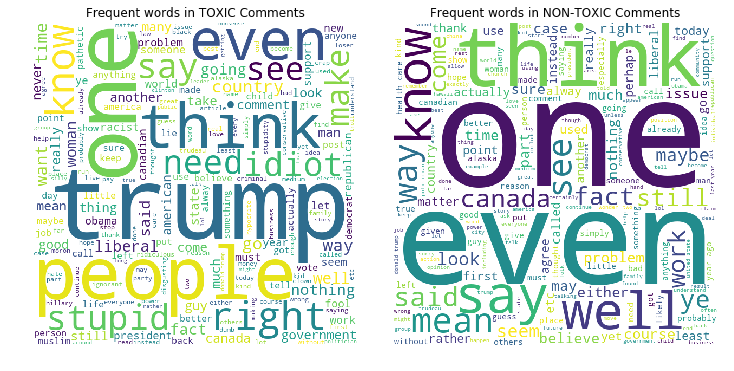


================================================== Frequent words in VALIDATION comments ==================================================


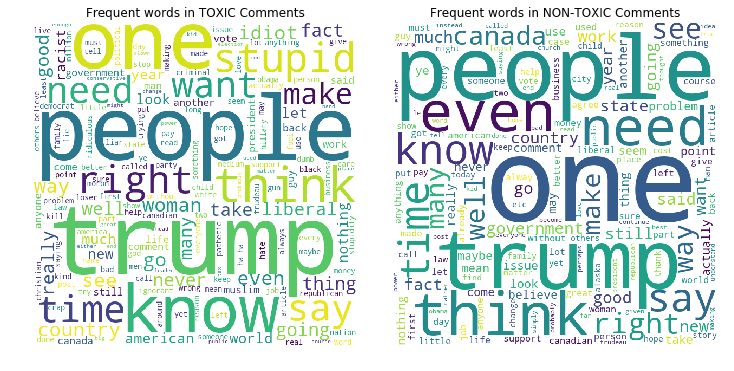

In [0]:
# @title Comments Analysis
from wordcloud import WordCloud, STOPWORDS 
# wordclouds for toxic and non-toxic data
def wordCloud_(df, title):
  stopwords = set(STOPWORDS)
  size = 600
  print("\n"+"="*50+" "+title+" "+"="*50)
  fig = plt.figure(figsize = (10, 10), facecolor = None) 
  ax = plt.subplot(1, 2, 1)
  corpus_toxic = df[df[TOXICITY_COLUMN]==True][TEXT_COLUMN].values
  corpus_toxic = ' '.join(corpus_toxic)
  wordcloud = WordCloud(width = size, height = size, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(corpus_toxic) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  ax.set_title("Frequent words in TOXIC Comments")
  plt.tight_layout(pad = 0) 
  
  ax = plt.subplot(1, 2, 2)
  corpus_toxic = df[df[TOXICITY_COLUMN]==False][TEXT_COLUMN].values
  corpus_toxic = ' '.join(corpus_toxic)
  wordcloud = WordCloud(width = size, height = size, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(corpus_toxic) 
  plt.imshow(wordcloud) 
  plt.axis("off") 
  plt.tight_layout(pad = 0) 
  ax.set_title("Frequent words in NON-TOXIC Comments")
  
  plt.show()
    
wordCloud_(train_df_float, "Frequent words in TRAINING comments") 
wordCloud_(validate_df_float, "Frequent words in VALIDATION comments") 
  

In [0]:
# @title Build Embeddings for comment words
def embedding_matrix(word_index):
  """
  Embedding matrix.
  We are combining two embeddings from fastcrawl-300d and glove-300d
  """
  # Load embeddings
  print('loading embeddings...')
  EMBEDDING_PATHS = [GLOVE_EMBEDDINGS_PATH,
                     CRAWL_EMBEDDINGS_PATH]
  embeddings_matrices = []
  for path in EMBEDDING_PATHS:
    embeddings_index = dict()
    with open(path) as f:
      for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

    embedding_matrix = np.zeros((len(word_index) + 1,
                                 GLOVE_EMBEDDINGS_DIMENSION))
    for word, i in word_index.items():
      try:
        embedding_matrix[i] = embeddings_index[word]
      except KeyError:
        pass
      except:
        embedding_matrix[i] = embeddings_index["unknown"]
    del embeddings_index
    garbageCollection()
    embeddings_matrices.append(embedding_matrix)

  print('building final embeddings...')
  embedding_matrix = np.concatenate(
    [f for f in embeddings_matrices], axis=-1) 
  return embedding_matrix

In [0]:
# @title Process Training Data for the Models
# Tokenizer
tokenizer = Tokenizer()
# we are fitting test set also here. 
# To give maximum vocabulary to our model.
tokenizer.fit_on_texts(list(train_df_float["comment_text"].values) 
                        + list(validate_df_float["comment_text"].values)
                         + list(test_df_float["comment_text"].values))
  
train_seq = tokenizer.texts_to_sequences(
      list(train_df_float["comment_text"].values))
validate_seq = tokenizer.texts_to_sequences(
      list(validate_df_float["comment_text"].values))
train_seq = pad_sequences(train_seq, maxlen=MAX_PAD_SEQ_LEN)
validate_seq = pad_sequences(validate_seq, maxlen=MAX_PAD_SEQ_LEN)

# labels
train_labels = train_df_float[TOXICITY_COLUMN]
train_aux_labels = train_df_float[AUXILARY_COLUMNS]
validate_labels = validate_df_float[TOXICITY_COLUMN]
validate_aux_labels = validate_df_float[AUXILARY_COLUMNS]

# SAMPLE WEIGHTS 
# Credits : https://www.kaggle.com/gpreda/jigsaw-fast-compact-solution
sample_weights = np.ones(len(train_df_float), dtype=np.float32)/4
sample_weights += train_df_float[IDENTITY_COLUMNS].sum(axis=1).astype(bool).astype(np.int) / 4
sample_weights += train_df_float[TOXICITY_COLUMN] * (~train_df_float[IDENTITY_COLUMNS]).sum(axis=1).astype(bool).astype(np.int) /4
sample_weights += (~train_df_float[TOXICITY_COLUMN]) * train_df_float[IDENTITY_COLUMNS].sum(axis=1).astype(bool).astype(np.int) /4
sample_weights /= sample_weights.mean()

# Embedding matrix.
embedding_matrix = embedding_matrix(tokenizer.word_index)

del train_df_float
garbageCollection()


loading embeddings...
Garbage collector: collected 75 objects.
Garbage collector: collected 0 objects.
building final embeddings...
Garbage collector: collected 7 objects.


In [0]:
# @title Model Validation Utility

SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df[df[subgroup]]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df[df[subgroup] & ~df[label]]
    non_subgroup_positive_examples = df[~df[subgroup] & df[label]]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df[df[subgroup] & df[label]]
    non_subgroup_negative_examples = df[~df[subgroup] & ~df[label]]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup,
            'subgroup_size': len(dataset[dataset[subgroup]])
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)


def calculate_overall_auc(df, model_name):
    true_labels = df[TOXICITY_COLUMN]
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)

def plot_auc_heatmap(bias_metrics_results, models):
  metrics_list = [SUBGROUP_AUC, BPSN_AUC, BNSP_AUC]
  df = bias_metrics_results.set_index('subgroup')
  columns = []
  vlines = [i * len(models) for i in range(len(metrics_list))]
  for metric in metrics_list:
    for model in models:
      columns.append(metric)
  num_rows = len(df)
  num_columns = len(columns)
  fig = plt.figure(figsize=(2*num_columns, 0.7 * num_rows))
  ax = sns.heatmap(df[columns], annot=True, fmt='.2', cbar=True, cmap='Reds_r',
                   vmin=0.5, vmax=1.0)
  ax.xaxis.tick_top()
  plt.xticks(rotation=90)
  ax.vlines(vlines, *ax.get_ylim())
  plt.title("Bias metric (auc scores) for various identities")
  return ax

def plot_histogram(non_toxic_scores, toxic_scores, description):
  NUM_BINS=15
  print("Comment count - Toxic = ", len(toxic_scores))
  print("Comment count - Non-Toxic = ", len(non_toxic_scores))
  sns.distplot(non_toxic_scores, norm_hist=True, bins=NUM_BINS, color=flatui[0], label='non-toxic ' + description, kde=False)
  ax = sns.distplot(toxic_scores, norm_hist=True, bins=NUM_BINS, color=flatui[1], label='toxic ' + description, kde=False)
  ax.set(xlabel='model toxicity score', ylabel='relative % of comments', yticklabels=[])
  plt.legend()
  plt.figure()

# Plot toxicity distributions of different identities to visualize bias.
def plot_histogram_for_identity(df, identity, model_name):
  toxic_scores = df.query(identity + ' == True & '+ TOXICITY_COLUMN+' == True')[model_name]
  non_toxic_scores = df.query(identity + ' == True &'+ TOXICITY_COLUMN+' == False')[model_name]
  print(identity + " : Comment count - Toxic = ", len(toxic_scores))
  print(identity + " : Comment count - Non-Toxic = ", len(non_toxic_scores))
  plot_histogram(non_toxic_scores, toxic_scores, 'labeled for ' + identity)

def plot_background_histogram(df, MODEL_NAME):
  toxic_scores = df.query(TOXICITY_COLUMN+' == True')[MODEL_NAME]
  non_toxic_scores = df.query(TOXICITY_COLUMN+' == False')[MODEL_NAME]
  plot_histogram(non_toxic_scores, toxic_scores, 'for all test data')
  
  
def validate_predictions(df, model_name, i_columns):
  bias_df = compute_bias_metrics_for_model(df, i_columns, model_name, TOXICITY_COLUMN, include_asegs=False)
  final_metric = get_final_metric(bias_df, calculate_overall_auc(df, model_name), POWER=-5, OVERALL_MODEL_WEIGHT=0.25)
  print("\n Final Metric Score : ", str(final_metric))
  print("--"*50)
  plot_auc_heatmap(bias_df, [model_name])
  plt.show()
  print("--"*50)
  # plot dist plots for toxic and non-toxic for each identity-label
  print("\nPlots showing toxic and nontoxic comments and their predicted behaviour.")
  plot_background_histogram(df, model_name)
  for i in i_columns:
    plot_histogram_for_identity(df, i, model_name)

In [0]:
# @title Model-1 Architecture and Build

def build_model(embedding_matrix, aux_target_count, 
                sample_weights,  model_name = "default"):
  print("Building model...")
  LSTM_UNITS = 128
  DENSE_HIDDEN_UNITS = 4*LSTM_UNITS
  # input layer
  sequence_input = Input(shape=(None,))
  # embedding layer
  embedding_layer = Embedding(embedding_matrix.shape[0], # input dimen.
                              embedding_matrix.shape[1], # output dimen.
                              weights=[embedding_matrix],
                              trainable=False
                              )(sequence_input)
  # spatial dropout dimen:1D
  sd = SpatialDropout1D(0.3)(embedding_layer)
  # Bidirectional layers
  x = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(sd)
  x = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x)
  hidden = concatenate([GlobalMaxPooling1D()(x),GlobalAveragePooling1D()(x),])
  # RNN units
  hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
  hidden = add([hidden, Dense(DENSE_HIDDEN_UNITS, activation='relu')(hidden)])
  # target output layer
  result = Dense(1, activation='sigmoid')(hidden)
  # auxilary outputs layer
  aux_result = Dense(aux_target_count, activation='sigmoid')(hidden)
    
  model = Model(inputs=sequence_input, outputs=[result, aux_result], name = model_name)
  model.compile(loss='binary_crossentropy', 
                 optimizer='adam')

  return model

In [0]:
# @title Train Model-1

model = build_model(embedding_matrix, len(AUXILARY_COLUMNS), 
                    sample_weights, model_name = "default_model")
print("="*25 + "Model Summary " + "="*25 )
print(model.summary())
print("="*50)

BATCH_SIZE = 1024
EPOCHS = 2
# Train model.
print('\n Training model...')
model.fit(train_seq,
            [train_labels, train_aux_labels],
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            validation_data=(validate_seq, [validate_labels, validate_aux_labels]),
            sample_weight=[sample_weights.values, np.ones_like(sample_weights)],
            verbose=1
            )
model.save(model.name+'sample_weights.h5')


Building model...





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
=========================Model Summary =========================
Model: "default_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 600)    164488200   input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, None, 600)    0           embedding_1[0][0]   


 Final Metric Score :  0.9241724915948193
----------------------------------------------------------------------------------------------------


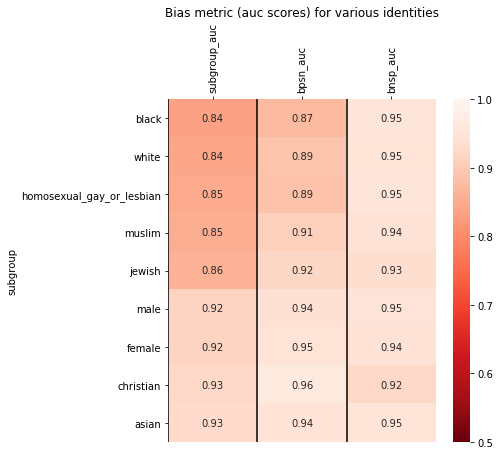

----------------------------------------------------------------------------------------------------

Plots showing toxic and nontoxic comments and their predicted behaviour.
Comment count - Toxic =  13093
Comment count - Non-Toxic =  148100
male : Comment count - Toxic =  646
male : Comment count - Non-Toxic =  3567
Comment count - Toxic =  646
Comment count - Non-Toxic =  3567
female : Comment count - Toxic =  737
female : Comment count - Non-Toxic =  4399
Comment count - Toxic =  737
Comment count - Non-Toxic =  4399
homosexual_gay_or_lesbian : Comment count - Toxic =  281
homosexual_gay_or_lesbian : Comment count - Non-Toxic =  671
Comment count - Toxic =  281
Comment count - Non-Toxic =  671
christian : Comment count - Toxic =  378
christian : Comment count - Non-Toxic =  3457
Comment count - Toxic =  378
Comment count - Non-Toxic =  3457
jewish : Comment count - Toxic =  126
jewish : Comment count - Non-Toxic =  590
Comment count - Toxic =  126
Comment count - Non-Toxic =  590
mu

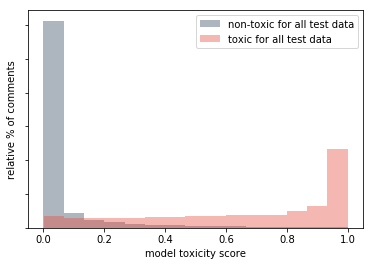

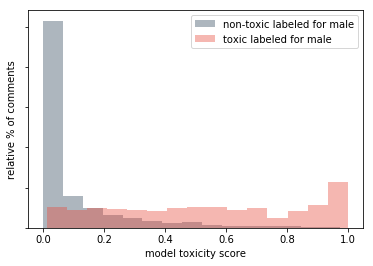

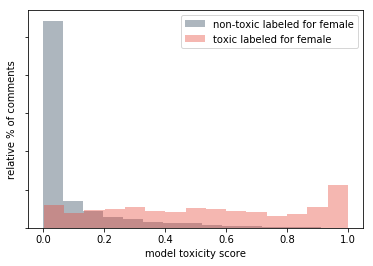

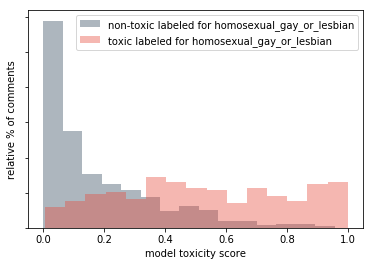

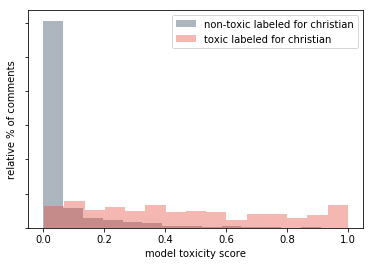

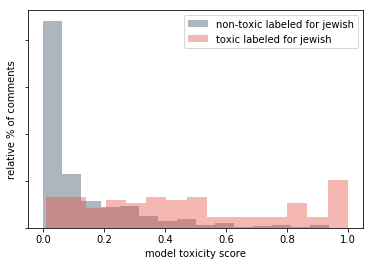

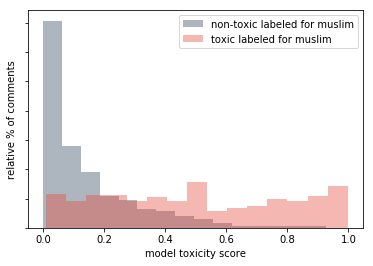

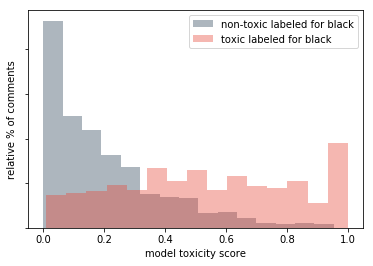

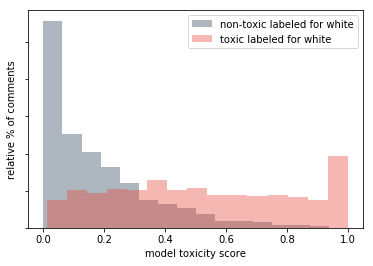

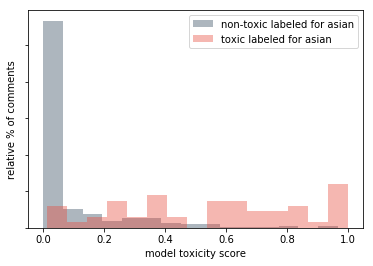

<Figure size 432x288 with 0 Axes>

In [0]:
# @title Model-1  Prediction Validation
all_predictions = model.predict(validate_seq, batch_size=1024)
validate_df_float[model.name]=all_predictions[0]
validate_predictions(validate_df_float, model.name, IDENTITY_COLUMNS)

In [0]:
# @title Model-1 Process Test Data && Get Results!
cols = [TEXT_COLUMN, TOXICITY_COLUMN] + AUXILARY_COLUMNS
# prepare comment data
test_comments = preprocess_text_data(comments = test_df_float[TEXT_COLUMN])
test_seq = tokenizer.texts_to_sequences(list(test_comments))
test_seq = pad_sequences(test_seq, maxlen=MAX_PAD_SEQ_LEN)

# predict comments
all_prediction = model.predict(test_seq, batch_size=1024, verbose =1)

# append predicted values to test dataframe .
test_df_float['prediction']=all_prediction[0]

predict_aux_columns = list()
# convert all list of lists to single list
for i in all_prediction[1]:
  predict_aux_columns.append(i)
test_aux_predictions = pd.DataFrame(predict_aux_columns, columns=AUXILARY_COLUMNS)
for i in AUXILARY_COLUMNS:
  test_df_float[i]=test_aux_predictions[i]

print('\n'+ '='*25 + 'Sample Prediction Comments' + "="*25)
print("\n", test_df_float[cols].head(10))

100%|██████████| 161233/161233 [01:18<00:00, 2050.26it/s]


161233/161233 [==============================] - 66s 412us/step

=========================Sample Prediction Comments=========================

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           comment_text  toxicity  severe_toxicity   obscene  identity_attack    insult    threat
0                                                                                                                                                                                                                                                                                      

In [0]:
# @title Model-2 Architecture and Build

def build_model2(input_length, embedding_matrix, aux_target_count, 
                sample_weights,  model_name = "default"):
  print("Building model...")
  LSTM_UNITS = 128
  DROPOUT_RATE = 0.3
  DENSE_HIDDEN_UNITS = 4*LSTM_UNITS
  # input layer
  sequence_input = Input(shape=(input_shape,))
  # embedding layer
  embedding_layer = Embedding(embedding_matrix.shape[0], # input dimen.
                              embedding_matrix.shape[1], # output dimen.
                              weights=[embedding_matrix],
                              input_length=input_length,
                              trainable=False
                              )(sequence_input)
  # spatial dropout dimen:1D
  sd = SpatialDropout1D(DROPOUT_RATE)(embedding_layer)
  # Bidirectional layers
  x = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(sd)
  x = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x)
  x = keras.layers.MaxPooling1D(2, padding='valid')(x)
  x = Bidirectional(CuDNNLSTM(LSTM_UNITS, return_sequences=True))(x)
  x = Dropout(DROPOUT_RATE)(x)  
  x = Flatten()(x)
  x = Dense(128, activation='relu')(x)
  result = Dense(1, activation='sigmoid')(x)
  # auxilary outputs layer
  aux_result = Dense(aux_target_count, activation='sigmoid')(x)
    
  model = Model(inputs=sequence_input, outputs=[result, aux_result], 
                name = model_name)
  model.compile(loss='binary_crossentropy', 
                 optimizer='adam')

  return model

In [0]:
# @title Train Model-2

model2 = build_model2(MAX_PAD_SEQ_LEN, embedding_matrix, len(AUXILARY_COLUMNS), 
                    sample_weights, model_name = "model2")
print("="*25 + " Model Summary " + "="*25 )
print(model2.summary())
print("="*50)

BATCH_SIZE = 1024
EPOCHS = 2
# Train model.
print('\n Training model...')
model2.fit(train_seq,
            [train_labels, train_aux_labels],
            batch_size=BATCH_SIZE,
            epochs=EPOCHS,
            validation_data=(validate_seq, [validate_labels, validate_aux_labels]),
            sample_weight=[sample_weights.values, np.ones_like(sample_weights)],
            verbose=1
            )
model2.save(model2.name+'sample_weights.h5')

Building model...
========================= Model Summary =========================
Model: "model2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 220)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 220, 600)     164488200   input_4[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d_3 (SpatialDro (None, 220, 600)     0           embedding_4[0][0]                
__________________________________________________________________________________________________
bidirectional_7 (Bidirectional) (None, 220, 256)     747520      spatial_dropout1d_3[0][0]        
_________


 Final Metric Score :  0.9205152832226051
----------------------------------------------------------------------------------------------------


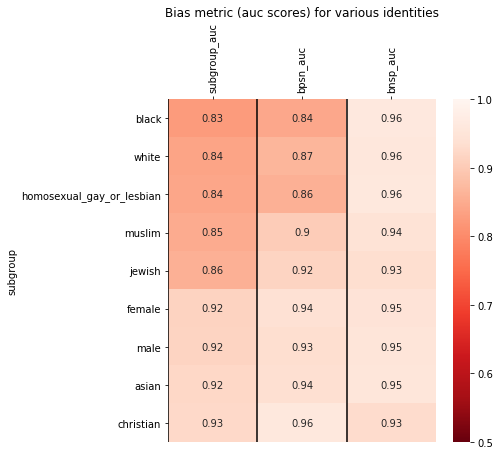

----------------------------------------------------------------------------------------------------

Plots showing toxic and nontoxic comments and their predicted behaviour.
Comment count - Toxic =  13093
Comment count - Non-Toxic =  148100
male : Comment count - Toxic =  646
male : Comment count - Non-Toxic =  3567
Comment count - Toxic =  646
Comment count - Non-Toxic =  3567
female : Comment count - Toxic =  737
female : Comment count - Non-Toxic =  4399
Comment count - Toxic =  737
Comment count - Non-Toxic =  4399
homosexual_gay_or_lesbian : Comment count - Toxic =  281
homosexual_gay_or_lesbian : Comment count - Non-Toxic =  671
Comment count - Toxic =  281
Comment count - Non-Toxic =  671
christian : Comment count - Toxic =  378
christian : Comment count - Non-Toxic =  3457
Comment count - Toxic =  378
Comment count - Non-Toxic =  3457
jewish : Comment count - Toxic =  126
jewish : Comment count - Non-Toxic =  590
Comment count - Toxic =  126
Comment count - Non-Toxic =  590
mu

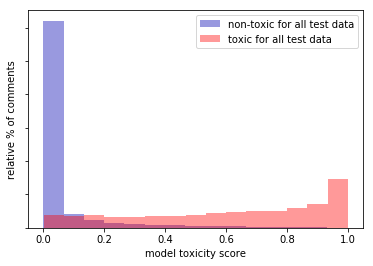

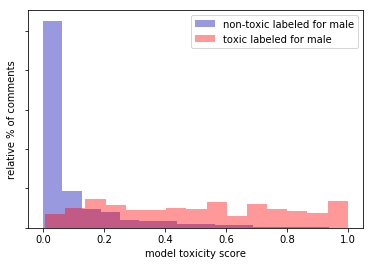

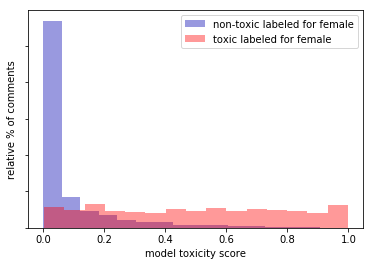

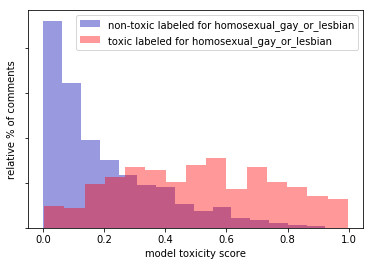

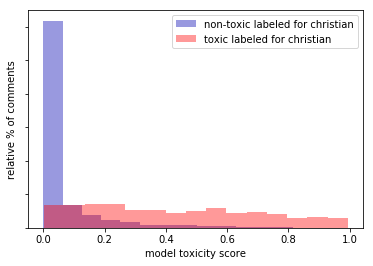

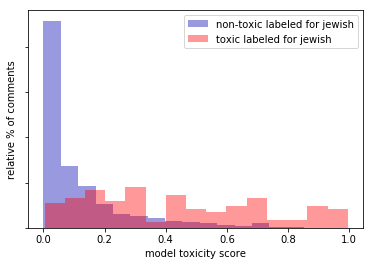

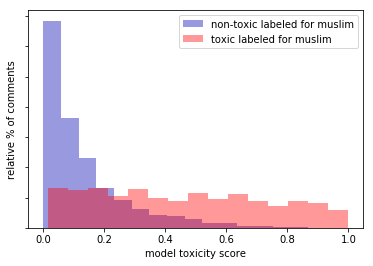

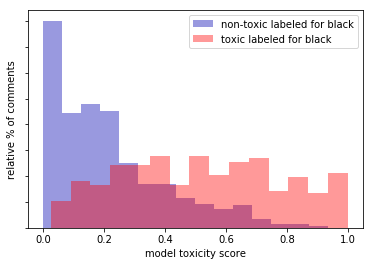

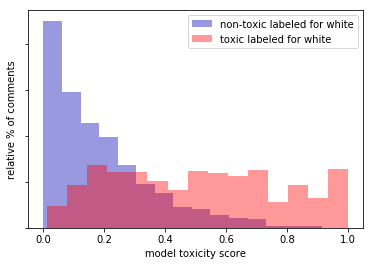

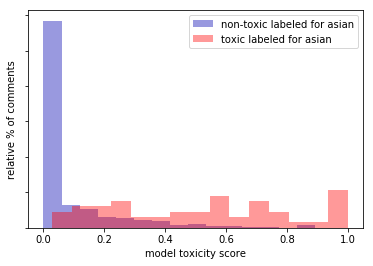

<Figure size 432x288 with 0 Axes>

In [0]:
# @title Model-2 Prediction Validation
all_predictions = model2.predict(validate_seq, batch_size=1024)
validate_df_float[model2.name]=all_predictions[0]
validate_predictions(validate_df_float, model2.name, IDENTITY_COLUMNS)

In [0]:
# @title Model-2 Process Test Data && Get Results!
cols = [TEXT_COLUMN, TOXICITY_COLUMN] + AUXILARY_COLUMNS
# prepare comment data
test_comments = preprocess_text_data(comments = test_df_float[TEXT_COLUMN])
test_seq = tokenizer.texts_to_sequences(list(test_comments))
test_seq = pad_sequences(test_seq, maxlen=MAX_PAD_SEQ_LEN)
# predict comments
all_prediction = model2.predict(test_seq, batch_size=1024, verbose =1)

# append predicted values to test dataframe .
test_df_float['prediction']=all_prediction[0]

predict_aux_columns = list()
# convert all list of lists to single list
for i in all_prediction[1]:
  predict_aux_columns.append(i)
test_aux_predictions = pd.DataFrame(predict_aux_columns, columns=AUXILARY_COLUMNS)
for i in AUXILARY_COLUMNS:
  test_df_float[i]=test_aux_predictions[i]

print('\n'+ '='*25 + 'Sample Prediction Comments' + "="*25)
print("\n", test_df_float[cols].head(10))

161233/161233 [==============================] - 82s 507us/step

=========================Sample Prediction Comments=========================

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           comment_text  toxicity  severe_toxicity   obscene  identity_attack    insult    threat
0                                                                                                                                                                                                                                                                                      

> ## **Conclusions:**

> * Improvement to my previous work.
> * Used data from civil_comments data.
> * Done basic preprocessing like converting all identities and target columns to boolean values.
> * From EDA, we can take max words count of all comments as 200 . Toxic comments
are 8% of overall comments. this means it is an imbalanced data. extracted features num_words and num_expressive_characters(question and punctuation marks count) doesn't impact in the separation of comments-not useful.
> * Preprocessed text data.
> Used GLOVE and FAST CRAWL 300d embeddings for comment text vectorization and modified sample weights as an improvement.
> Defined bias metrics from google bench mark kernel. and model validation graphs based on google-tutorial
> I tried two models: first model architecture is very popular bidirectional- lstms with RNN's across kaggle kernels gave final metric - 0.924 and second model architecture having with Maxpoolingbetween and Flattening and dense layer gave a final score of 0.921. 


**Note:** We can improve the model giving full train data further.

**I've used embeddings having a static vector for each word independent of their context. A major improvement can be acheived with context based word-embeddings using bert, xlnet models and finetuning them.**

In [2]:
# @title 
from prettytable import PrettyTable
from prettytable import ALL
pt = PrettyTable(hrules = ALL)
pt.field_names = ["S.No", "Model Architecture", "CV Final AUC score"]
pt.add_row(["1", "2 bidirect-LSTM, MaxPooling, bidirect-LSTM,\nflattening, dense(128) with sample weights", "0.921"])
pt.add_row(["2", "2 bidirect-LSTM, concat(globalMaxpooling, globalAveragepooling),\n2 rnn units with sample weights.", "0.924"])
print(pt)

+------+------------------------------------------------------------------+--------------------+
| S.No |                        Model Architecture                        | CV Final AUC score |
+------+------------------------------------------------------------------+--------------------+
|  1   |           2 bidirect-LSTM, MaxPooling, bidirect-LSTM,            |       0.921        |
|      |            flattening, dense(128) with sample weights            |                    |
+------+------------------------------------------------------------------+--------------------+
|  2   | 2 bidirect-LSTM, concat(globalMaxpooling, globalAveragepooling), |       0.924        |
|      |                 2 rnn units with sample weights.                 |                    |
+------+------------------------------------------------------------------+--------------------+
